# Import Libraries

In [1]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Model
from keras.layers import Input, Embedding, LSTM, Bidirectional, Dropout, Dense, Concatenate
from keras.optimizers import Adam
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import WordCloud



# Download necessary NLTK data
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

catatanm nltk (Natural Language Toolkit) adalah sebuah library Python yang sangat populer untuk pengolahan bahasa alami 

# get data

In [2]:
# Load the dataset
url = "https://raw.githubusercontent.com/AsukaaNao/datasets/refs/heads/main/cyberbullying_tweets.csv"
data = pd.read_csv(url)

# Makesure all of the attribuites are in string format
data['tweet_text'] = data['tweet_text'].astype(str)
data['cyberbullying_type'] = data['cyberbullying_type'].astype(str)
data.head()

,tweet_text,cyberbullying_type
0,"In other words #katandandre, your food was cra...",not_cyberbullying
1,Why is #aussietv so white? #MKR #theblock #ImA...,not_cyberbullying
2,@XochitlSuckkks a classy whore? Or more red ve...,not_cyberbullying
3,"@Jason_Gio meh. :P thanks for the heads up, b...",not_cyberbullying
4,@RudhoeEnglish This is an ISIS account pretend...,not_cyberbullying


# EDA

In [3]:
data.describe()

,tweet_text,cyberbullying_type
count,47692,47692
unique,46017,6
top,RT @sailorhg: the intro for my hardware hackin...,religion
freq,2,7998


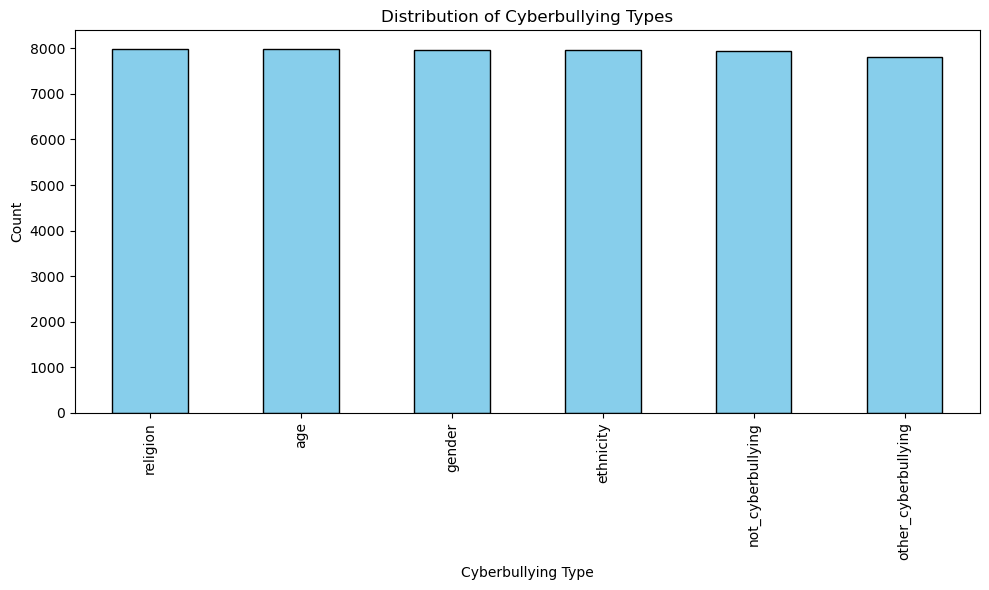

In [4]:
import matplotlib.pyplot as plt

# Plotting the distribution of 'cyberbullying_type'
plt.figure(figsize=(10,6))
data['cyberbullying_type'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')

# Adding labels and title
plt.xlabel('Cyberbullying Type')
plt.ylabel('Count')
plt.title('Distribution of Cyberbullying Types')

# Show the plot
plt.tight_layout()
plt.show()


### The distribution of the dataset is pretty balanced, no need balancing.

# preprocessing

In [5]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Ensure necessary NLTK data packages are downloaded
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('vader_lexicon') 
nltk.download('vader_lexicon')

# Define stopwords and common slang dictionary
stop_words = set(stopwords.words('english'))
# Customize stopwords (some how theese word are abundant in the dataset)
stop_words.add('rt')  # Add 'rt'
stop_words.add('u')   # Add 'u'

# Mapping for internet slang/abbreviations
slang_dict = {
    "idk": "i don't know",
    "wtd": "what to do",
    "btw": "by the way",
    "omg": "oh my god",
    "ttyl": "talk to you later",
    "brb": "be right back",
    "lol": "laughing out loud",
    "lmao": "laughing my ass off",
    "rofl": "rolling on the floor laughing",
    "smh": "shaking my head",
    "tbh": "to be honest",
    "wtf": "what the fuck",
    "omw": "on my way",
    "fyi": "for your information",
    "imo": "in my opinion",
    "ikr": "i know, right",
    "nvm": "never mind",
    "ftw": "for the win",
    "thx": "thanks",
    "np": "no problem",
    "gtg": "got to go",
    "afk": "away from keyboard",
    "bff": "best friends forever",
    "wyd": "what are you doing",
    "hbu": "how about you",
    "ily": "i love you",
    "omfg": "oh my fucking god",
    "gg": "good game",
    "gr8": "great",
    "yolo": "you only live once",
    "tmi": "too much information",
    "stfu": "shut the fuck up",
    "btfo": "back the fuck off",
    "wtg": "way to go",
    "srsly": "seriously",
    "jk": "just kidding",
    "hbd": "happy birthday",
    "asap": "as soon as possible",
    "fml": "fuck my life",
    "ty": "thank you",
    "np": "no problem",
    "ikr": "i know, right",
    "idc": "i don't care",
    "ttfn": "ta ta for now",
    "dw": "don't worry",
    "rn": "right now",
    "rt" : "retweet",
}

# Initialize SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

# Function to clean and preprocess tweets
def preprocess_tweet(tweet):
    # Remove URLs
    tweet = re.sub(r'http\S+|www\S+', '', tweet)
    # Remove mentions
    tweet = re.sub(r'@\w+', '', tweet)
    # Remove hashtags but keep the text (e.g., #happy -> happy)
    tweet = re.sub(r'#', '', tweet)
    # Convert tweet to lowercase
    tweet = tweet.lower()
    # Replace slang with their mapped meaning
    words = tweet.split()
    words = [slang_dict.get(word.lower(), word) for word in words]
    tweet = ' '.join(words)
    
    # Tokenize and remove stopwords while preserving sentence context
    tokens = word_tokenize(tweet)
    tokens = [word for word in tokens if word.lower() not in stop_words]
    
    
    # Rejoin tokens to form the cleaned sentence
    cleaned_tweet = ' '.join(tokens)
    # Sentiment analysis to detect bullying context
    sentiment = sia.polarity_scores(tweet)  # Get sentiment scores
    
    # If sentiment is negative, it's more likely to be bullying
    if sentiment['compound'] <= -0.3:  # You can adjust the threshold as needed
        # Add a flag indicating potential bullying
        cleaned_tweet += " [bullying]"
    
    return cleaned_tweet
    


# Apply preprocessing
data['tweet_text'] = data['tweet_text'].apply(preprocess_tweet)

# Display sample results
print(data[['tweet_text']].head())

encoding_map = {
    'not_cyberbullying': 0,
    'gender': 1,
    'religion': 2,
    'other_cyberbullying': 3,
    'age': 4,
    'ethnicity': 5
}

# Remove duplicate tweets
data = data.drop_duplicates(subset=['tweet_text'], keep='first')

# Apply the mapping to the 'cyberbullying_type' column
data['cyberbullying_type'] = data['cyberbullying_type'].map(encoding_map) #sebenarnya langsung nanti aja di onehot encoding

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\bryan\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


                                          tweet_text
0        words katandandre , food crapilicious ! mkr
1  aussietv white ? mkr theblock imacelebrityau t...
2    classy whore ? red velvet cupcakes ? [bullying]
3  meh . : p thanks heads , concerned another ang...
4  isis account pretending kurdish account . like...


catatan, tidak lemination dan setmming supaya model dapat lebih paham variasi kata  agar lebih mengetahui konteks
lemming lebih detail adripada stemming namun lebih lambat

kenapa tanda baca tidak dihapus?
menunjukan emosi dan intensitas baca

In [6]:
#see the procesed tweets
data.head()

,tweet_text,cyberbullying_type
0,"words katandandre , food crapilicious ! mkr",0
1,aussietv white ? mkr theblock imacelebrityau t...,0
2,classy whore ? red velvet cupcakes ? [bullying],0
3,"meh . : p thanks heads , concerned another ang...",0
4,isis account pretending kurdish account . like...,0


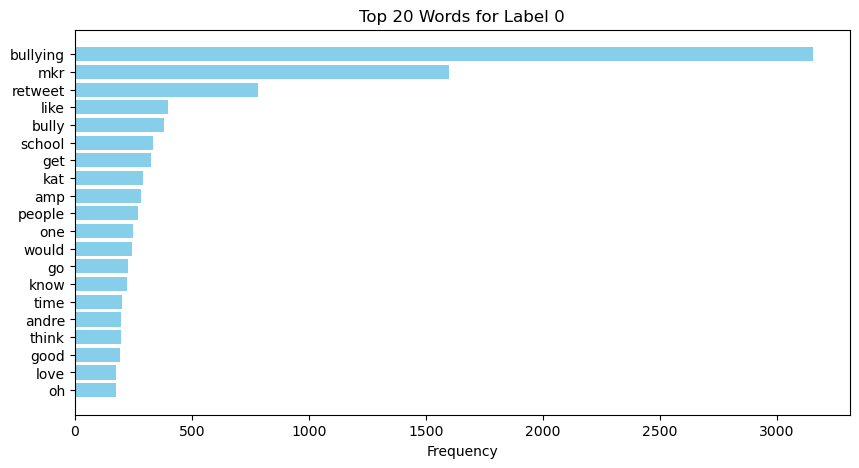

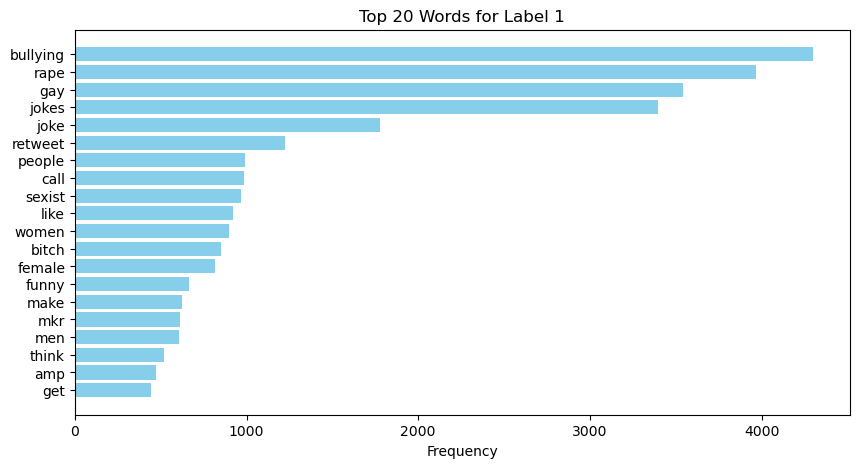

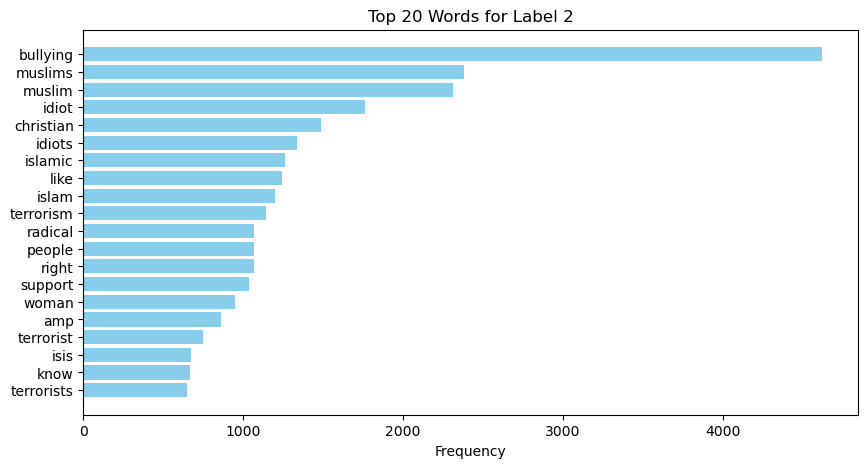

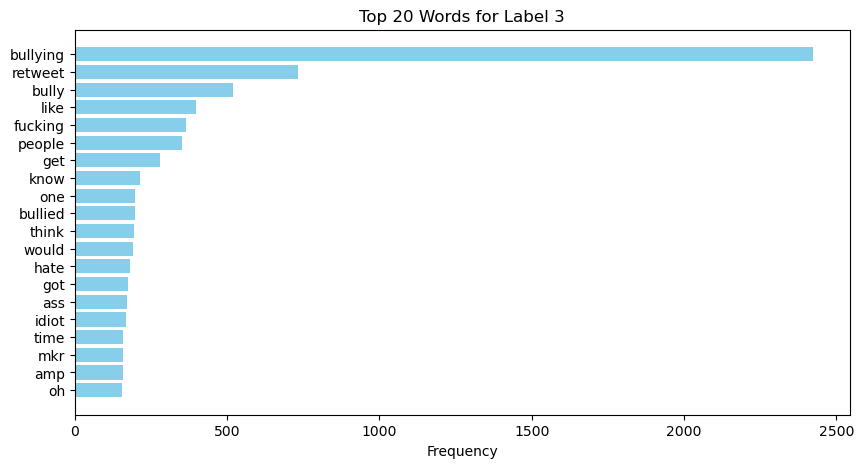

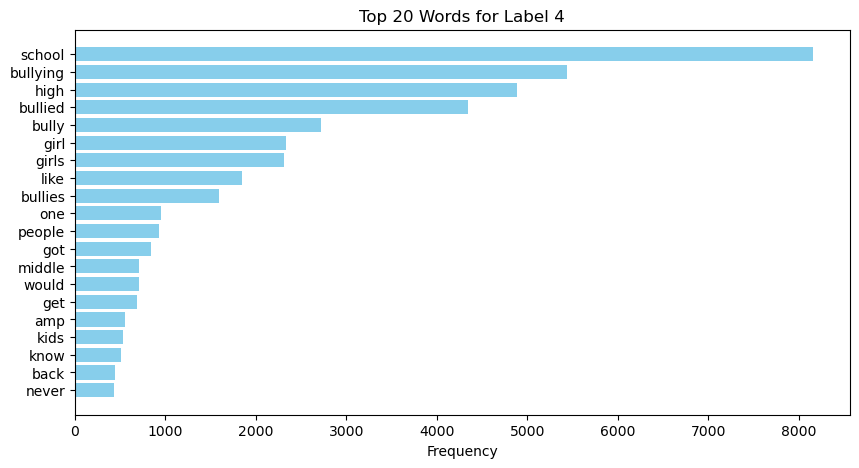

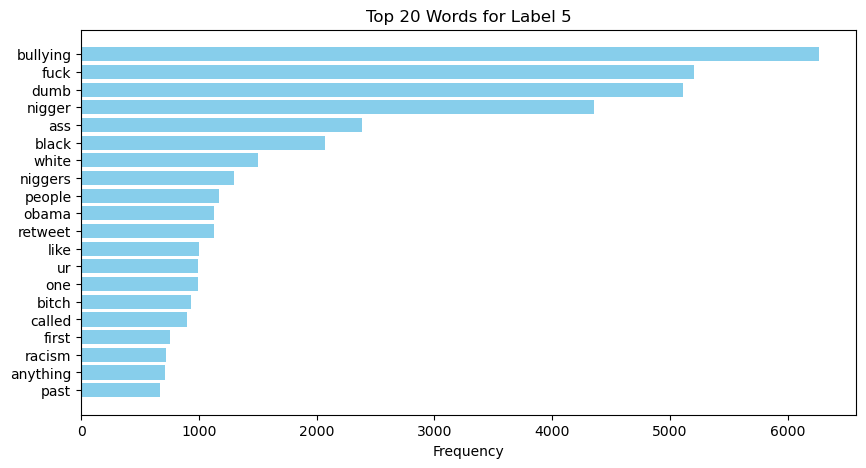

In [7]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to preprocess and tokenize tweets
def get_word_frequency(tweets):
    all_words = []
    for tweet in tweets:
        tokens = word_tokenize(tweet)
        filtered_tokens = [word.lower() for word in tokens if word.isalpha()]
        all_words.extend(filtered_tokens)
    return Counter(all_words)

# Initialize a dictionary to store word frequencies for each label
label_word_freq = {}

# Loop through each unique label in 'cyberbullying_type' and calculate word frequencies
for label in data['cyberbullying_type'].unique():
    label_tweets = data[data['cyberbullying_type'] == label]['tweet_text']
    label_word_freq[label] = get_word_frequency(label_tweets)

# Convert word frequency counters to DataFrames and sort them
label_word_freq_df = {}
for label, word_freq in label_word_freq.items():
    word_freq_df = pd.DataFrame(word_freq.items(), columns=['Word', 'Frequency'])
    word_freq_df = word_freq_df.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
    label_word_freq_df[label] = word_freq_df

import matplotlib.pyplot as plt

# Display the top 20 words for each label as a separate bar chart
for label, word_freq_df in label_word_freq_df.items():
    # Select the top 20 words
    top_20_words = word_freq_df.head(20)
    
    # Create a bar chart
    plt.figure(figsize=(10, 5))
    plt.barh(top_20_words['Word'], top_20_words['Frequency'], color='skyblue')
    plt.xlabel('Frequency')
    plt.title(f'Top 20 Words for Label {label}')
    plt.gca().invert_yaxis()  # Invert y-axis to display the highest frequency at the top
    plt.show()


catatan, menggunakan TF (term frequency)

TF-IDF lebih berfokus pada menghitung pentingnya kata-kata dalam dokumen atau kumpulan dokumen. Ini tidak selalu membantu dalam mengidentifikasi apakah kata-kata tersebut digunakan dengan cara yang menyakitkan atau merendahkan.

In [8]:
data.head()

,tweet_text,cyberbullying_type
0,"words katandandre , food crapilicious ! mkr",0
1,aussietv white ? mkr theblock imacelebrityau t...,0
2,classy whore ? red velvet cupcakes ? [bullying],0
3,"meh . : p thanks heads , concerned another ang...",0
4,isis account pretending kurdish account . like...,0


# modeling

In [9]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Tokenize the cleaned tweets
tokenizer = Tokenizer(num_words=5000)  # Limit to the top 5000 most frequent words
tokenizer.fit_on_texts(data['tweet_text'])

# Convert tweets to sequences of integers
X = tokenizer.texts_to_sequences(data['tweet_text'])

# Pad sequences to ensure they have the same length
max_length = 100  # You can adjust this based on the average tweet length
X = pad_sequences(X, padding='post', maxlen=max_length)

#catatan, Fungsi pad_sequences di Keras digunakan untuk memastikan bahwa semua urutan (sequences) dalam data memiliki panjang yang sama. 

# Define the target variable (encoded labels)
y = data['cyberbullying_type']

# Apply one-hot encoding for multi-class classification
y = to_categorical(y, num_classes=len(encoding_map))  # Convert labels to one-hot encoded format (akhirnya di onehot)

# Split the data into training and testing sets (90% train, 10% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

labels = data['cyberbullying_type']

# Class weights for imbalanced dataset
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels.values
)
class_weights_dict = dict(zip(np.unique(labels), class_weights))

print(class_weights_dict)

# Calculate class weights to handle imbalanced classes
class_weights = {0: 1, 1: 1, 2: 1, 3: 1, 4: 1, 5: 1}  # because the class weight is simmilar, so all get 1 as the weight

# Build the model
model = Sequential([
    Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=256, input_length=max_length),  # embedding_dim = 256
    Bidirectional(LSTM(64, return_sequences=False)),  # lstm_units = 64
    Dropout(0.3),  # dropout_rate = 0.3
    Dense(64, activation='relu'),  # dense_units = 64
    Dropout(0.3),  # dropout_rate = 0.3
    Dense(len(encoding_map), activation='softmax')  # Use softmax for multi-class classification
])

# Compile the model with the specified learning rate
optimizer = Adam(learning_rate=0.0001)  # learning_rate = 0.0001
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Summary of the model
model.summary()

# Early stopping callback (early stopping if the vall los keep increasing, to prevent overfitting)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=11,
    batch_size=32,
    validation_data=(X_test, y_test),
    # class_weight=class_weights,
    # uncomment if wanna do early stopping
    callbacks=[early_stopping],
    verbose=2
)

# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {accuracy*100:.2f}%")

# Predict cyberbullying labels for the test set
y_pred = model.predict(X_test)
y_pred = y_pred.argmax(axis=1)  # Convert one-hot predictions to class labels

# Convert one-hot encoded labels back to class labels for the test set
y_test_labels = y_test.argmax(axis=1)

# Classification report
print(classification_report(y_test_labels, y_pred))




{0: 0.9716989247311828, 1: 0.9769935997232313, 2: 0.9447580813783297, 3: 1.26247555183012, 4: 0.9491639358037139, 5: 0.9585879158180584}


c:\Users\bryan\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/11
1271/1271 - 182s - 143ms/step - accuracy: 0.6292 - loss: 0.9377 - val_accuracy: 0.8008 - val_loss: 0.4697
Epoch 2/11
1271/1271 - 170s - 134ms/step - accuracy: 0.7925 - loss: 0.4799 - val_accuracy: 0.8261 - val_loss: 0.4208
Epoch 3/11
1271/1271 - 184s - 145ms/step - accuracy: 0.8183 - loss: 0.4180 - val_accuracy: 0.8298 - val_loss: 0.3994
Epoch 4/11
1271/1271 - 153s - 120ms/step - accuracy: 0.8419 - loss: 0.3781 - val_accuracy: 0.8451 - val_loss: 0.3963
Epoch 5/11
1271/1271 - 151s - 119ms/step - accuracy: 0.8612 - loss: 0.3444 - val_accuracy: 0.8482 - val_loss: 0.3931
Epoch 6/11
1271/1271 - 146s - 115ms/step - accuracy: 0.8745 - loss: 0.3174 - val_accuracy: 0.8493 - val_loss: 0.4044
Epoch 7/11
1271/1271 - 149s - 117ms/step - accuracy: 0.8845 - loss: 0.2934 - val_accuracy: 0.8416 - val_loss: 0.4080
Epoch 8/11
1271/1271 - 147s - 116ms/step - accuracy: 0.8926 - loss: 0.2764 - val_accuracy: 0.8393 - val_loss: 0.4293
142/142 - 2s - 12ms/step - accuracy: 0.8482 - loss: 0.3931
Test 

catetan, 
Embedding Layer untuk mengubah kata menjadi vektor numerik.
Bidirectional LSTM untuk menangkap konteks dari kedua arah dalam urutan teks.
Dropout untuk mencegah overfitting. 
Dense Layer dengan ReLU untuk memperkenalkan non-linearitas dan pembelajaran fitur lebih kompleks.
Output Layer dengan Softmax untuk klasifikasi multi-kelas.
Adam Optimizer untuk optimasi yang efisien.
Categorical Crossentropy Loss untuk masalah klasifikasi multi-kelas.


LSTM (Long Short-Term Memory) adalah jenis jaringan saraf berulang (RNN) yang sangat baik dalam menangani data urutan, seperti teks. LSTM dapat mempelajari dependensi jangka panjang dalam data urutan yang sering kali diperlukan dalam analisis teks.
128 adalah jumlah unit (neuron) dalam LSTM. Ini mengontrol kapasitas model untuk menangkap pola yang kompleks dalam data. Jumlah 128 adalah nilai yang cukup umum dan seimbang antara performa dan efisiensi komputasi.
Dengan Bidirectional, model dapat mengakses informasi dari kedua sisi kalimat, meningkatkan kemampuannya dalam memahami konteks keseluruhan.

Dropout adalah teknik regularisasi yang digunakan untuk mencegah overfitting, yaitu fenomena di mana model terlalu menyesuaikan diri dengan data pelatihan dan kehilangan kemampuannya untuk menggeneralisasi pada data baru.
Pada Dropout(0.5), selama pelatihan, 50% dari neuron akan "dihapus" atau dipadamkan secara acak, sehingga model tidak terlalu bergantung pada neuron tertentu dan dapat belajar fitur yang lebih general.

Dense layer adalah layer feedforward biasa yang digunakan untuk pemrosesan data setelah ekstraksi fitur dari layer sebelumnya. Jumlah neuron 64 adalah nilai yang cukup umum untuk layer tersembunyi dan memberi keseimbangan yang baik antara kapasitas model dan efisiensi komputasi.
Activation='relu':
ReLU (Rectified Linear Unit) adalah fungsi aktivasi yang sangat populer untuk layer tersembunyi. ReLU memberikan hasil yang lebih baik dalam banyak kasus karena memecahkan masalah vanishing gradient yang ada pada fungsi aktivasi lain seperti sigmoid atau tanh.
ReLU mengubah nilai negatif menjadi nol dan membiarkan nilai positif tetap utuh, yang memungkinkan model untuk belajar lebih cepat dan lebih efektif.
ReLU sangat sederhana secara komputasi: ia hanya menghasilkan output 0 jika input negatif dan output yang sama dengan input jika input positif (yaitu f(x)=max(0,x)).ReLU sangat efektif digunakan pada jaringan saraf dalam (deep neural networks) yang memiliki banyak lapisan (layers), di mana masalah vanishing gradient (penurunan gradien yang sangat kecil selama pelatihan) dapat terjadi pada fungsi aktivasi lain seperti sigmoid atau tanh. ReLU tidak mengalami masalah ini, karena gradiennya tetap konstan (positif) pada nilai input yang lebih besar dari nol.

Dense(len(encoding_map)):
Dense layer terakhir ini memiliki jumlah neuron yang sama dengan jumlah kelas target yang ingin diprediksi. Dalam hal ini, jumlah kelas adalah jumlah unik dari cyberbullying_type, yang ada dalam encoding_map. Setiap neuron di output akan mewakili salah satu kelas dalam masalah klasifikasi multi-kelas.
Activation='softmax':
Softmax digunakan di layer output dalam klasifikasi multi-kelas karena ia mengubah output menjadi probabilitas. Dengan softmax, setiap output akan berada dalam rentang 0 hingga 1 dan jumlah semua probabilitas akan sama dengan 1. Model akan memprediksi kelas dengan probabilitas tertinggi sebagai kelas yang dipilih.

Adam adalah optimizer yang sering digunakan untuk model pembelajaran mendalam. Adam adalah singkatan dari Adaptive Moment Estimation, yang menggabungkan keuntungan dari dua optimizer sebelumnya: AdaGrad dan RMSProp. Adam secara otomatis menyesuaikan laju pembelajaran untuk setiap parameter dan bekerja sangat baik dalam banyak kasus untuk model yang lebih kompleks.
. Keuntungan Adam:
Menggunakan Momentum: Seperti momentum klasik, Adam menggunakan rata-rata gradien sebelumnya untuk membuat pembaruan parameter lebih stabil dan lebih cepat.
Laju Pembelajaran yang Adaptif: Adam mengubah laju pembelajaran untuk setiap parameter secara dinamis, berdasarkan seberapa besar gradien yang diterima dari parameter tersebut. Dengan demikian, parameter dengan gradien besar mendapat pembaruan yang lebih kecil, sementara parameter dengan gradien kecil mendapatkan pembaruan yang lebih besar.
Tidak Memerlukan Penyesuaian Laju Pembelajaran Manual: Adam dapat bekerja dengan baik dalam banyak kasus tanpa memerlukan penyesuaian manual terhadap laju pembelajaran, karena ia secara otomatis mengadaptasi pembaruan berdasarkan data.
Cocok untuk Masalah dengan Banyak Data dan Parameter: Karena Adam dapat menangani parameter dengan gradien yang sangat berbeda (seperti dalam jaringan saraf dalam), ia cocok untuk masalah yang lebih kompleks seperti NLP, gambar, atau masalah deret wakt

Categorical Crossentropy digunakan karena ini adalah masalah klasifikasi multi-kelas. Fungsi loss ini mengukur perbedaan antara distribusi probabilitas prediksi model dan distribusi label yang benar (dalam bentuk one-hot encoding).

# Evaluation

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.66      0.65       790
           1       0.90      0.84      0.87       766
           2       0.95      0.96      0.95       827
           3       0.59      0.62      0.60       579
           4       0.96      0.98      0.97       785
           5       0.98      0.97      0.98       772

    accuracy                           0.85      4519
   macro avg       0.84      0.84      0.84      4519
weighted avg       0.85      0.85      0.85      4519



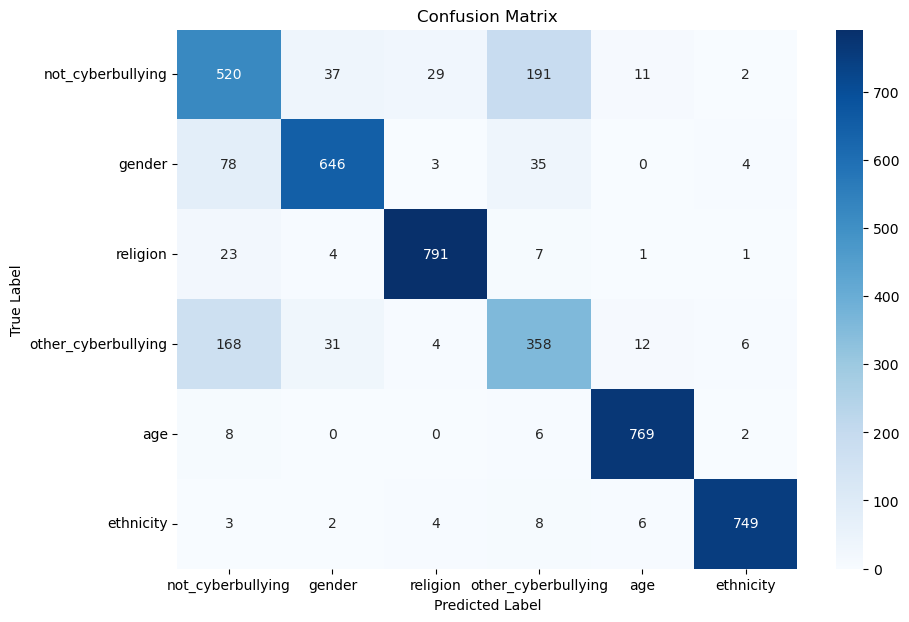

Overall Accuracy: 84.82%


In [10]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Generate classification report
print("Classification Report:")
print(classification_report(y_test_labels, y_pred))

# Generate confusion matrix
cm = confusion_matrix(y_test_labels, y_pred)

# Display confusion matrix as heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=list(encoding_map.keys()), yticklabels=list(encoding_map.keys()))
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Calculate and display accuracy
accuracy = accuracy_score(y_test_labels, y_pred)
print(f"Overall Accuracy: {accuracy * 100:.2f}%")


### The accuracy is more than 0.75 as stated in our proposal, but alittle bit of confusion in other_bullying and non_bullying (the dataset is simmilar)

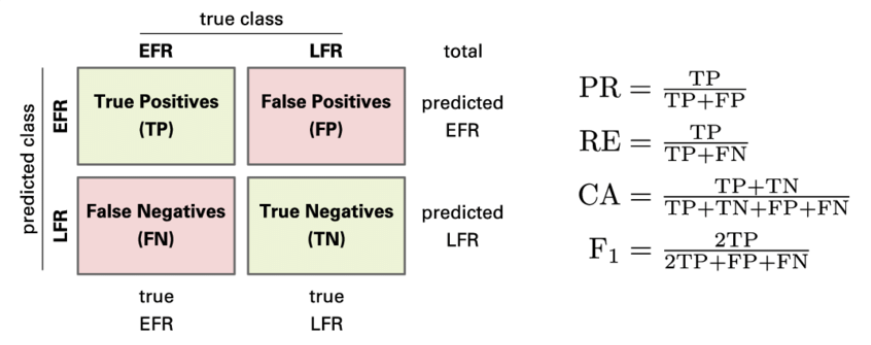

catatan, 2 class teresebut falsepositive akrena sensifity flag mungkin terlalu rendah

# Testing

In [11]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Function to predict the class labels of input text
def predict_text_array(text_array, tokenizer, model, max_length, preprocess_function, encoding_map):
    # Preprocess the input array of text
    cleaned_texts = [preprocess_function(text) for text in text_array]

    # Convert the cleaned texts to sequences
    text_sequences = tokenizer.texts_to_sequences(cleaned_texts)

    # Pad the sequences to ensure they are of uniform length
    padded_sequences = pad_sequences(text_sequences, padding='post', maxlen=max_length)

    # Prepare sentiment input using SentimentIntensityAnalyzer
    sentiment_scores = [
        sia.polarity_scores(preprocess_function(text))['compound'] for text in text_array
    ]  # Extract compound sentiment scores
    sentiment_input = np.array(sentiment_scores).reshape(-1, 1)  # Reshape for model input

    # Predict the cyberbullying type for each input text
    predictions = model.predict([padded_sequences, sentiment_input])  # Pass both inputs

    predicted_class_indices = predictions.argmax(axis=1)  # Get the predicted class indices

    # Map the predicted indices back to class labels
    index_to_label = {v: k for k, v in encoding_map.items()}
    predicted_labels = [index_to_label[idx] for idx in predicted_class_indices]

    return predicted_labels

# Define max_length based on your model's input sequence length (typically set during training)
# max_length = X_text.shape[1]  # Use the sequence length from training data

# Example text array for prediction
text_array = [
    "You are so annoying and stupid.",
    "You are not annoying and not stupid.",
    "This is a wonderful and positive day!",
    "I think you are being harassed online.",
    "Neutral and boring sentence.",
    "Offensive and abusive words are here.",
    "i'm muslim and i'm proud and i like it",
    "he is not retard",
    "he is retard",
    "she is not a good person",
    "she is a good person",
    "fucking moslems terrorists",
    "i'm islam",
    "usually girls are bad, but they are actually good at everything you know",
    "I love hummans, there great!"
]

# Predict the labels for the input text array
predicted_labels = predict_text_array(
    text_array=text_array,
    tokenizer=tokenizer,
    model=model,
    max_length=max_length,
    preprocess_function=preprocess_tweet,
    encoding_map=encoding_map
)

# Print results
for text, label in zip(text_array, predicted_labels):
    print(f"Text: '{text}' -> Predicted Label: {label}")

c:\Users\bryan\anaconda3\Lib\site-packages\keras\src\models\functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor
Received: inputs=('Tensor(shape=(15, 100))', 'Tensor(shape=(15, 1))')
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
Text: 'You are so annoying and stupid.' -> Predicted Label: other_cyberbullying
Text: 'You are not annoying and not stupid.' -> Predicted Label: other_cyberbullying
Text: 'This is a wonderful and positive day!' -> Predicted Label: not_cyberbullying
Text: 'I think you are being harassed online.' -> Predicted Label: not_cyberbullying
Text: 'Neutral and boring sentence.' -> Predicted Label: not_cyberbullying
Text: 'Offensive and abusive words are here.' -> Predicted Label: other_cyberbullying
Text: 'i'm muslim and i'm proud and i like it' -> Predicted Label: not_cyberbullying
Text: 'he is not retard' -> Predicted Label: other_cyberbullying
Text: 'he is retard' -> Predicted Label: other_cyberbullying
Text: 'she is not a good person' -> Predicted Label: not_cyberbullying
Text: 'she is a good person' -> Predicted Label: other_cyberbullying
Text: 'fucking moslems terrorists' -> Predicted Label: other_cyberbullying
Text: 'i'm islam' -> Predicted Label: no

In [14]:
#save model
import pickle
model.save('cyberbullying_model_with_best_parameter.h5')

# Save the tokenizer to a file
with open('tokenizercyberv2.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)